In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from IPython.display import Image, display_png

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg
Qt5Agg: unable to import specified backend (or its dependency); no plots


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

In [3]:
exp_type = 'centroid_fwhm'

In [4]:
#base_dir = Path(aps.__file__).parents[1]
#autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/")
data_base_dir = autoalign_dir / exp_type
print(f'data base dir exists {data_base_dir.exists()}')


data base dir exists True


In [5]:
!ls {data_base_dir}

centroid_fwhm_150_2022-11-18_images
centroid_fwhm_150_2022-11-18_steps
centroid_fwhm_75_2022-11-17.png
centroid_fwhm_autofocusing.ini
centroid_fwhm_optimization_final_150_2022-11-18_13:00.pkl
centroid_fwhm_optimization_final_75_2022-11-17_16:00.pkl
final_setup_2022-11-18.png
initial_setup_2022_11_18.png


### peak_fwhm_150_2022-11-21

In [6]:
!ls {data_base_dir}

centroid_fwhm_150_2022-11-18_images
centroid_fwhm_150_2022-11-18_steps
centroid_fwhm_75_2022-11-17.png
centroid_fwhm_autofocusing.ini
centroid_fwhm_optimization_final_150_2022-11-18_13:00.pkl
centroid_fwhm_optimization_final_75_2022-11-17_16:00.pkl
final_setup_2022-11-18.png
initial_setup_2022_11_18.png


CA client library is unable to contact CA repeater after 50 tries.
Silence this message by starting a CA repeater daemon
or by calling ca_pend_event() and or ca_poll() more often.


In [7]:
log_file = Path(data_base_dir / 'centroid_fwhm_optimization_final_150_2022-11-18_13:00.pkl')
log_file.exists()

True

In [8]:
hist_dir = Path(data_base_dir / 'centroid_fwhm_150_2022-11-18_steps')
hist_dir.exists()

True

In [16]:
study = analysis.create_study_from_trials(log_file, n_objectives=2)

[I 2022-11-29 15:11:25,768] A new study created in memory with name: no-name-24bc2cc0-7328-4081-b901-2fd5fc604868


Assuming minimization for all objectives.


In [17]:
n_steps = len(study.trials)

In [18]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='pkl')

Trial values: centroid_distance 5.975e-03 fwhm 3.937e-02 
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.390024449573547, 'h_fwhm': 0.036416859657251166, 'h_centroid': -0.0036781130971529352, 'h_peak': -0.05430013895321907, 'v_sigma': 0.45698579053964605, 'v_fwhm': 0.01495584212583112, 'v_centroid': 0.00470905253851156, 'v_peak': 0.013980461117623974, 'integral_intensity': 285.98098396737913, 'peak_intensity': 40755.0, 'gaussian_fit': {}}}


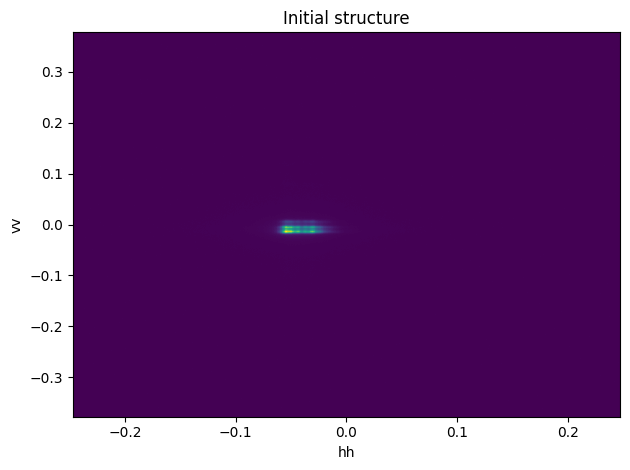

In [19]:
print(f"Trial values: centroid_distance {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e} ")
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)


plt.pcolormesh(hists[0].hh[700:-700], hists[0].vv[700:-700], hists[0].data_2D[700:-700,700:-700].T)
plt.xlabel('hh')
plt.ylabel('vv')
plt.title("Initial structure")
plt.tight_layout()
plt.show()

In [20]:
analysis.select_nash_equil_trial_from_pareto_front??

Signature:
analysis.select_nash_equil_trial_from_pareto_front(
    study: optuna.study.study.Study,
) -> Tuple[optuna.trial._frozen.FrozenTrial, int, Sequence[int]]
Source:   
def select_nash_equil_trial_from_pareto_front(study: optuna.Study) -> Tuple[FrozenTrial, int, Sequence[int]]:
    """This identifies the nash equilibrium = the trial that dominates the most number of trials"""
    n_dominated = calculate_dominated_trials(study.best_trials, study.trials, study.directions)
    ix = np.argmax(n_dominated)
    return study.best_trials[ix], ix, n_dominated
File:      ~/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/analysis_utils.py
Type:      function


In [21]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [22]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[117, 139, 123, 142, 91, 59]
109 [0.0002636314379277681, 0.011504617267917006]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3894961090995303, 'h_fwhm': 0.008453913849004735, 'h_centroid': -0.0002517003474366841, 'h_peak': -0.012680870773506308, 'v_sigma': 0.45702302013369284, 'v_fwhm': 0.007803048065651019, 'v_centroid': 7.84121812227867e-05, 'v_peak': 0.0777053536537709, 'integral_intensity': 286.4317739547632, 'peak_intensity': 65324.152, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 0.011504617267917006


Trial number 56
Trial values: peak_distance 1.674e-04 fwhm 1.432e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.38980956870986266, 'h_fwhm': 0.009104214914312792, 'h_centroid': 0.00016556015091168108, 'h_peak': -0.0009754515979620237, 'v_sigma': 0.45729028282665457, 'v_fwhm': 0.01105431809300561, 'v_centroid': 2.47902838078351e-05, 'v_peak': 0.07575459163735822, 'integral_intensity': 286.4330459202676, 'peak_intensity': 65343.203, 'gaussian_fit': {}}}
Actual fwhm 0.014320777831785068


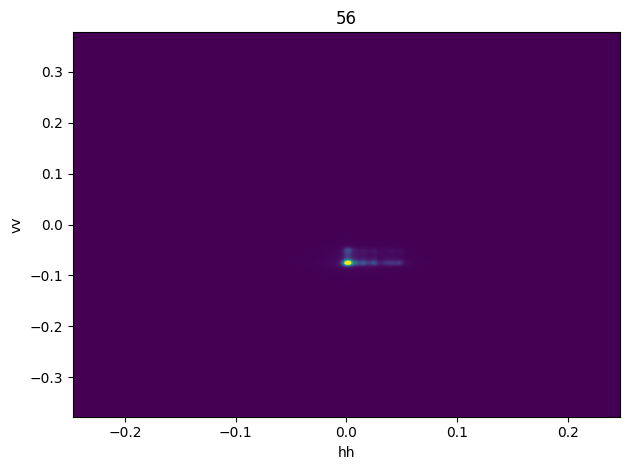

Trial number 100
Trial values: peak_distance 1.962e-04 fwhm 1.199e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3896860590366555, 'h_fwhm': 0.009104214914312792, 'h_centroid': -0.00017546928772624315, 'h_peak': -0.004877257989810118, 'v_sigma': 0.4574281851917597, 'v_fwhm': 0.007803048065651019, 'v_centroid': -8.774229521013588e-05, 'v_peak': 0.08225713169206711, 'integral_intensity': 286.082308198199, 'peak_intensity': 65408.277, 'gaussian_fit': {}}}
Actual fwhm 0.011990591658498573


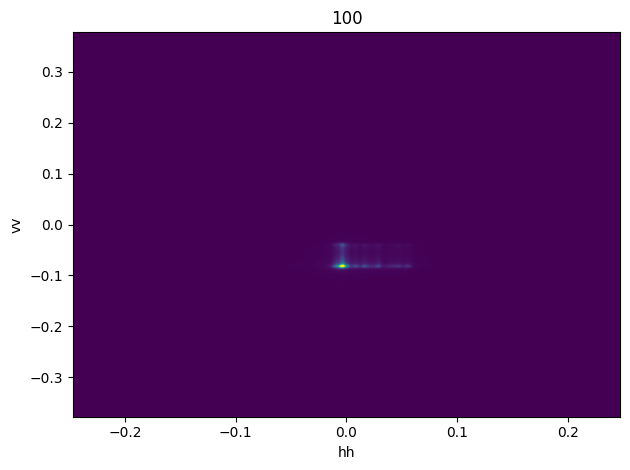

Trial number 105
Trial values: peak_distance 8.256e-04 fwhm 1.150e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3895666052007003, 'h_fwhm': 0.0078036127836966784, 'h_centroid': 0.00037838604609308213, 'h_peak': -0.00032515053265395866, 'v_sigma': 0.4572879366293928, 'v_fwhm': 0.008453302071121938, 'v_centroid': -0.0007337893553190922, 'v_peak': 0.08810941774130515, 'integral_intensity': 286.4684715127203, 'peak_intensity': 65240.55, 'gaussian_fit': {}}}
Actual fwhm 0.011504550768435448


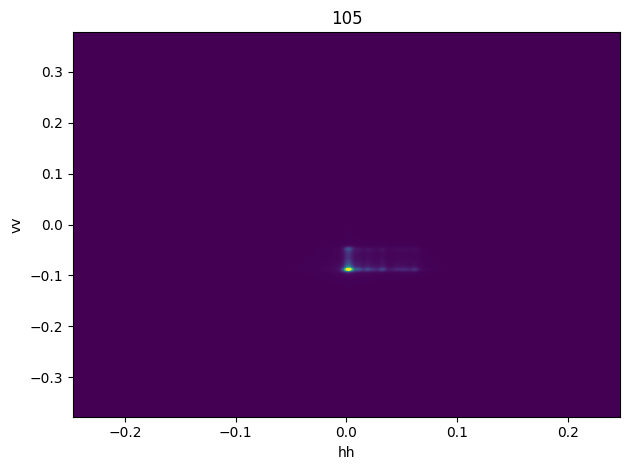

Trial number 109
Trial values: peak_distance 2.636e-04 fwhm 1.150e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3894961090995303, 'h_fwhm': 0.008453913849004735, 'h_centroid': -0.0002517003474366841, 'h_peak': -0.012680870773506308, 'v_sigma': 0.45702302013369284, 'v_fwhm': 0.007803048065651019, 'v_centroid': 7.84121812227867e-05, 'v_peak': 0.0777053536537709, 'integral_intensity': 286.4317739547632, 'peak_intensity': 65324.152, 'gaussian_fit': {}}}
Actual fwhm 0.011504617267917006


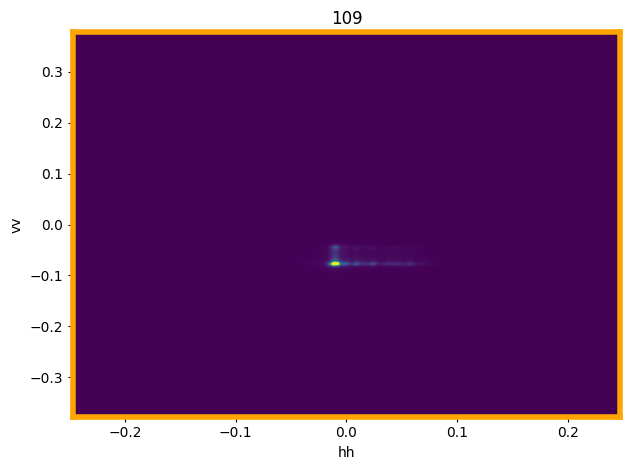

Trial number 112
Trial values: peak_distance 1.482e-03 fwhm 1.107e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.38959736652995347, 'h_fwhm': 0.007153311718388622, 'h_centroid': -0.0004947816201363309, 'h_peak': -0.0224353867531264, 'v_sigma': 0.45732763933390963, 'v_fwhm': 0.008453302071121938, 'v_centroid': -0.0013974856960028426, 'v_peak': 0.09656271981242673, 'integral_intensity': 286.3600567507908, 'peak_intensity': 65380.18, 'gaussian_fit': {}}}
Actual fwhm 0.011073761079509997


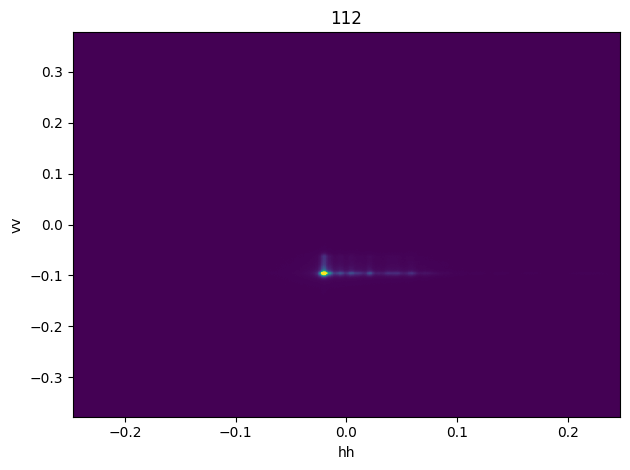

Trial number 150
Trial values: peak_distance 2.678e-03 fwhm 1.059e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.38949076413076616, 'h_fwhm': 0.0078036127836966784, 'h_centroid': -0.0011548052835771982, 'h_peak': -0.024386289949050448, 'v_sigma': 0.4573845044652401, 'v_fwhm': 0.007152794060180101, 'v_centroid': -0.0024162143807168746, 'v_peak': 0.11021805392731535, 'integral_intensity': 286.6947189939313, 'peak_intensity': 65365.195, 'gaussian_fit': {}}}
Actual fwhm 0.010585784588079523


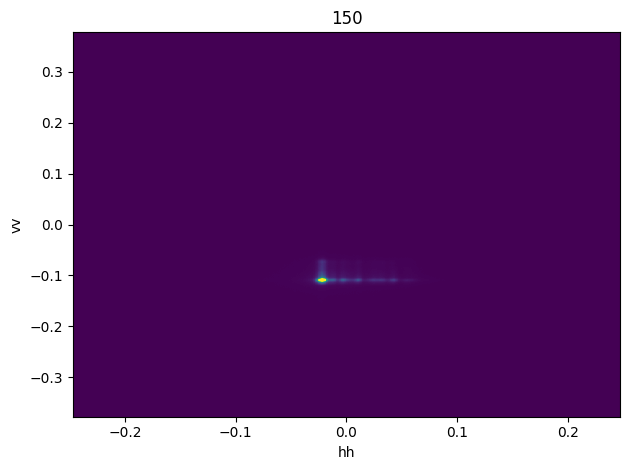

In [23]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.pcolormesh(hist.hh[700:-700], hist.vv[700:-700], hist.data_2D[700:-700,700:-700].T)
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color('orange')
    plt.xlabel('hh')
    plt.ylabel('vv')
    plt.title(t.number)
    plt.tight_layout()
    plt.show()

In [24]:
study.best_trials[0].values

[0.00016740585933942582, 0.014320777831785068]

In [26]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ['centroid', 'fwhm'])

In [27]:
pareto_df

,number,centroid,fwhm,h_peak,v_peak,h_fwhm,v_fwhm,peak_intensity
56,56,0.000167,0.014321,-0.000975,0.075755,0.009104,0.011054,65343.203125
100,100,0.000196,0.011991,-0.004877,0.082257,0.009104,0.007803,65408.277344
105,105,0.000826,0.011505,-0.000325,0.088109,0.007804,0.008453,65240.550781
109,109,0.000264,0.011505,-0.012681,0.077705,0.008454,0.007803,65324.152344
112,112,0.001482,0.011074,-0.022435,0.096563,0.007153,0.008453,65380.179688
150,150,0.002678,0.010586,-0.024386,0.110218,0.007804,0.007153,65365.195312


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_47619/508936459.py:3: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["centroid", "fwhm"], include_dominated_trials=False)


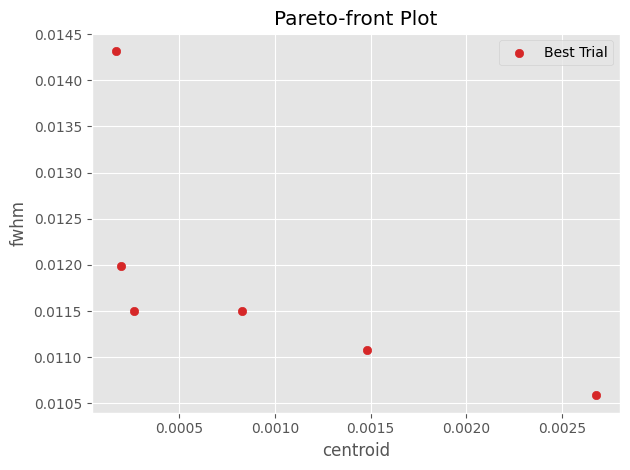

In [28]:
# Generating the pareto front for the multiobjective optimization

optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["centroid", "fwhm"], include_dominated_trials=False)
#plt.scatter(*nash_trial.values, color='orange', label='Nash')
plt.legend(loc='best')
plt.tight_layout()

# plt.savefig(...) to save the image
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_47619/2220557095.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="centroid")


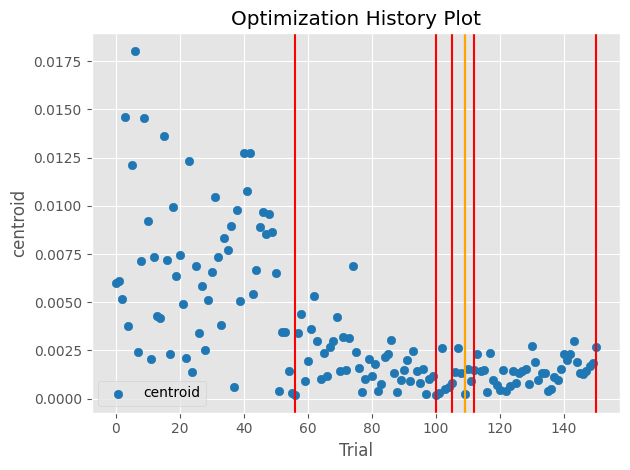

In [29]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="centroid")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_47619/2080699662.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], target_name="fwhm")


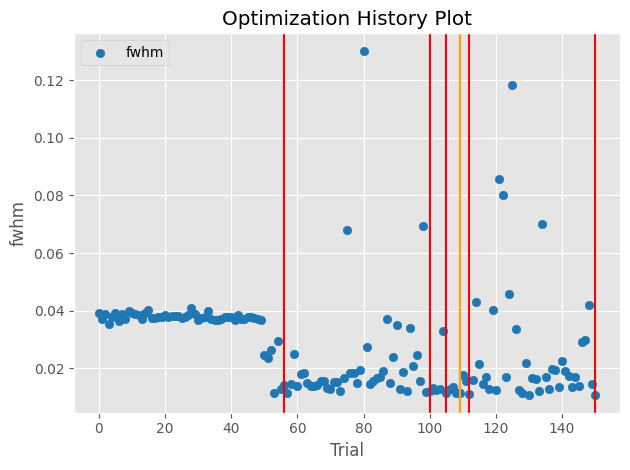

In [30]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], target_name="fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### The remaining part is just testing how lwsi with thresholding performs in selecting the structures. This is for my own satisfaction. - SK

In [31]:
isums = []
wsums_no_thres = []
wsums_thres = []
for h in hists:
    isum1, wsum1 = analysis.calculate_weighted_sum(h, threshold=0)
    isum2, wsum2 = analysis.calculate_weighted_sum(h)
    isums.append((isum1, isum2))
    wsums_no_thres.append(wsum1)
    wsums_thres.append(wsum2)
isums = np.array(isums)
wsums_no_thres = np.array(wsums_no_thres)
wsums_thres = np.array(wsums_thres)
                      

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_47619/214102518.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),


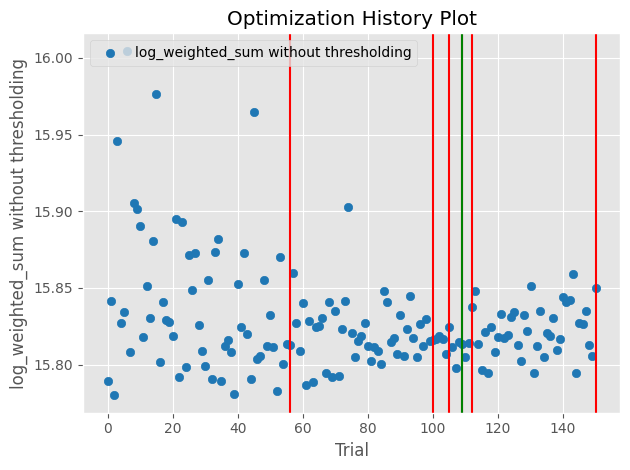

In [32]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),
                                                          target_name="log_weighted_sum without thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_47619/2958963105.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),


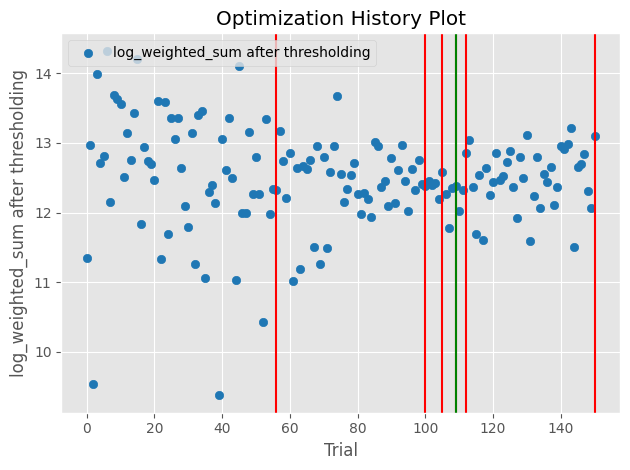

In [33]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),
                                                          target_name="log_weighted_sum after thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [36]:
test_val_fns = [lambda t: t.values[1], lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, study.directions, values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins))

69


39 [0.037834539659595816, 9.370050191822102]


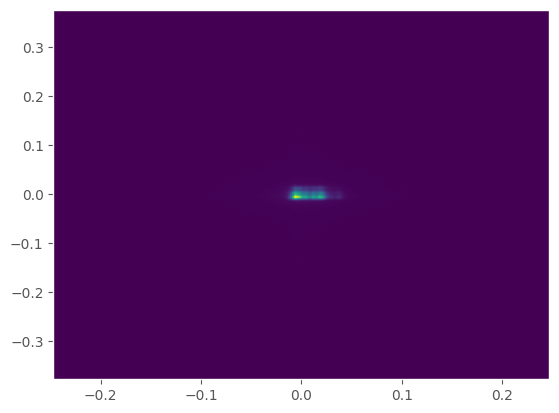

52 [0.02621304394694098, 10.423379328470979]


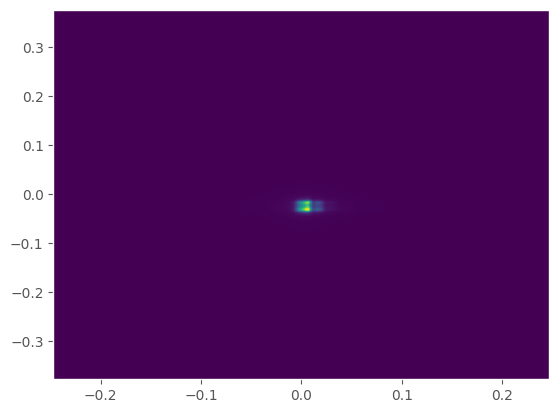

61 [0.017985887487747862, 11.01463609819793]


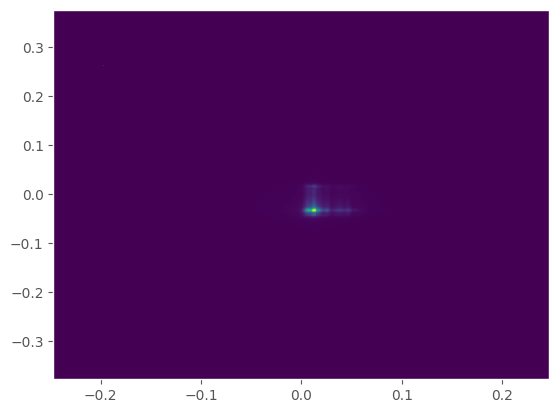

63 [0.014742877858418896, 11.194326216618771]


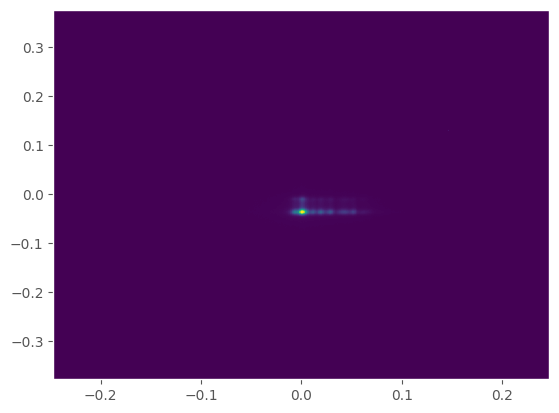

69 [0.01316731177190838, 11.255977045497504]


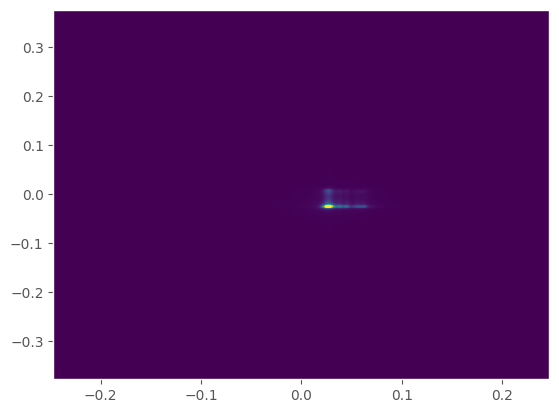

105 [0.011504550768435448, 12.579240140100818]


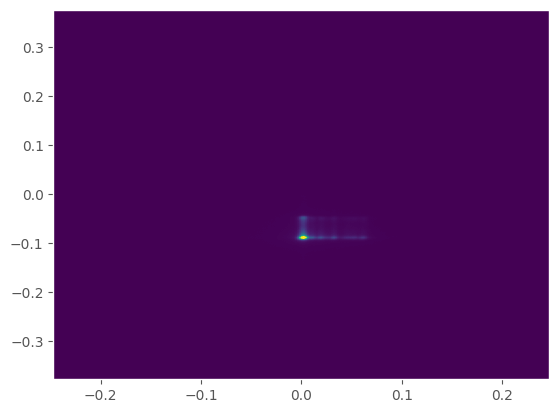

108 [0.011504617267917006, 12.351657897268456]


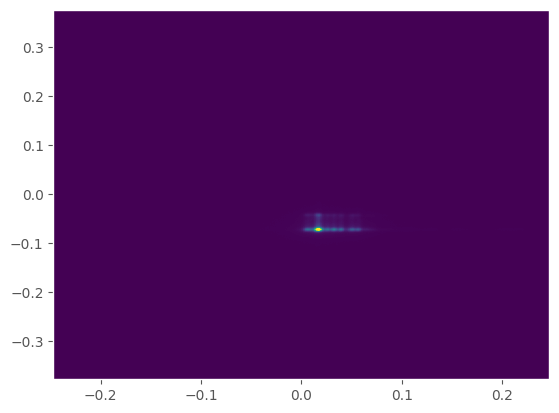

112 [0.011073761079509997, 12.857797032845479]


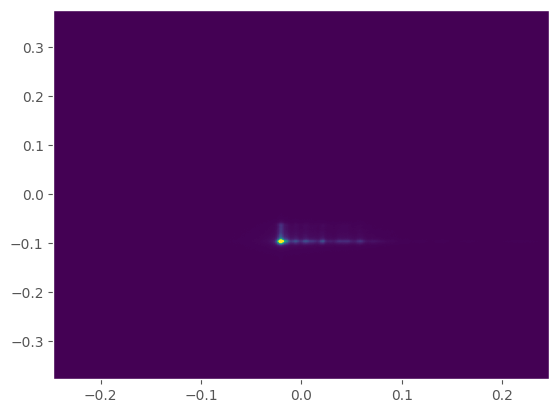

127 [0.012491324333105883, 11.916536397654166]


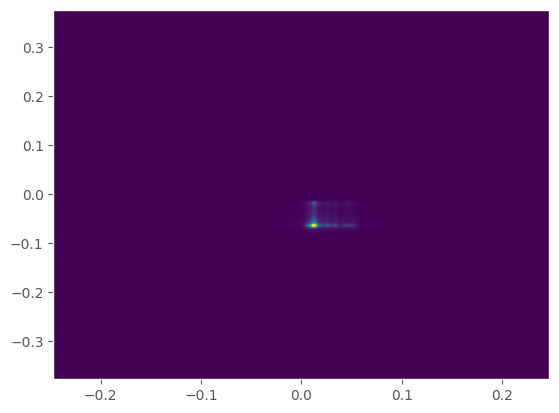

150 [0.010585784588079523, 13.095736873945535]


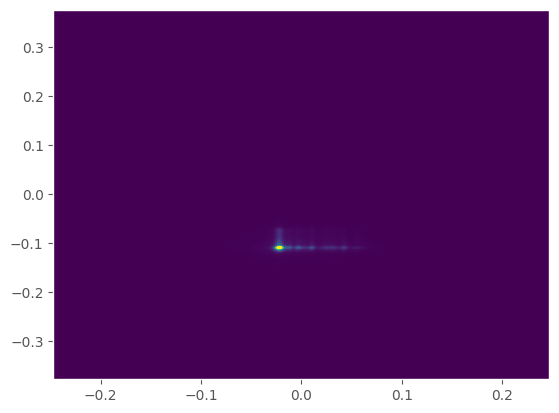

In [37]:
for t in test_pareto:
    print(t.number, test_values[t.number])
    hdata = hists[t.number]
    
    plt.pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T)
    plt.show()

In [38]:
test_val_fns = [lambda t: t.values[0], lambda t: opt_common._get_fwhm_from_dw(t.user_attrs['dw']), lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1], values_fns=test_val_fns)

domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), domins[np.argmax(domins)])

TypeError: object of type 'ValueError' has no len()

error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
CAC: error = "Network is unreachable" sending UDP msg to 192.168.0.255:5064
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Network is unreachable"
error sending registration message to CA repeater daemon was "Ne